## Introduction
Social reinforcement can play a crucial role in behavioral adoption. When the primary function of a behavior is social, such as for term adoption or fashion, the largest factor for whether an individual adopts a new behavior may be the behaviors in their reference network. We explore the question of how social network structure and individual factors affect the propagation of these behaviors. We construct an agent-based model which allows us to simulate behavior propagation in social networks. We simulate propagation in networks where two competing behaviors are present and observe the impacts of population size, connectivity, initial prevalence, and learning rate on dispersion over time. We give particular focus to the question of how trends emerge.

In [2]:
# Execute this once, the first time you run
!pip install networkx

import warnings
warnings.filterwarnings('ignore')

You are using pip version 9.0.1, however version 9.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [10]:
# You must restart the kernel if you wish to rerun this cell -- cannot overwrite an existing SparkContext

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.types import *
import pyspark.sql.functions as F

from pyspark.sql.functions import lit
from pyspark.storagelevel import StorageLevel
import random



#spark = SparkSession.builder.appName('Networks').config('spark.executor.memory', '4g').getOrCreate()
#sc = SparkContext(conf=SparkConf().set('spark.driver.memory', '4g')).getOrCreate()
#sqlContext = SQLContext(sc)


## Creating the Network

This notebook allows the simulation of behavioral adoption in a network, where some initial behavior exists, and a new competing behavior is introduced by a subset of the agents. A network can be created with parameters describing the size, connectivity, propensity to act, and speed of behavioral change.

In [2]:
'''
size: number of people in the network
edge_prob: between 0 and 1, random graph, likelihood of any edge existing
prior: between 0 and 1, initial likelihood of taking new action
memory: between 0 and 1, weight of old prior when updating after observation
'''

param_dict = {'size': 50,
              'prior': 0.5,
              'edge_prob': 0.1,
              'memory': 0,
              'rounds': 10}

agent_schema = StructType([StructField('node', IntegerType(), True), StructField('last_action', IntegerType(), True), StructField('prior', FloatType(), True)])
edge_schema = StructType([StructField('from_node', IntegerType(), True), StructField('to_node', IntegerType(), True)])


def build_network(params):
    edges = []
    for i in range(params['size']):
        for j in range(i+1, params['size']):
            x = random.random()
            if x < params['edge_prob']:
                edges.append([i,j])
                edges.append([j,i])
    
    agents_sdf = spark.createDataFrame([[i, 0, params['prior']] for i in range(params['size'])], agent_schema)
    edges_sdf = spark.createDataFrame(edges, edge_schema)
    
    agents_sdf = agents_sdf.persist(StorageLevel.MEMORY_AND_DISK).repartition(100, 'node').cache()
    edges_sdf = edges_sdf.persist(StorageLevel.MEMORY_AND_DISK).repartition(100, 'from_node').cache()
    return (agents_sdf, edges_sdf)

## Generating Behavior and Updating Priors

We simulate a round of behavior by having each agent act probabilistically according to their prior, and then updating priors for each agent to reflect the distribution of actions played by their reference network in the previous round. The following cells implement each action once, and below we provide methods for running many rounds.

In [3]:
import random
from pyspark.sql.functions import udf

# returns 1 with probability p
def act_from_prior(p):
    x = random.random()
    return 1 if p > x else 0
    
action_udf_int = udf(lambda z: act_from_prior(z), IntegerType())

In [11]:
agents_sdf.createOrReplaceTempView('agents_sdf_view')
agents_sdf = agents_sdf.select('node', action_udf_int('prior').alias('last_action'), 'prior')

+----+-----------+-----+
|node|last_action|prior|
+----+-----------+-----+
|  39|          1| 0.45|
|  14|          1| 0.45|
|  40|          0| 0.45|
|  22|          0| 0.45|
|  12|          1| 0.45|
|  26|          1| 0.45|
|  37|          1| 0.45|
|  23|          1| 0.45|
|  34|          1| 0.45|
|  35|          0| 0.45|
|  31|          1| 0.45|
|  43|          1| 0.45|
|  16|          0| 0.45|
|   8|          0| 0.45|
|  27|          0| 0.45|
|  18|          1| 0.45|
|   3|          0| 0.45|
|  48|          0| 0.45|
|  15|          0| 0.45|
|  30|          0| 0.45|
+----+-----------+-----+
only showing top 20 rows



In [12]:
agents_sdf.createOrReplaceTempView('agents_sdf_view')
edges_sdf.createOrReplaceTempView('edges_sdf_view')
agents_sdf = spark.sql("SELECT A.node, A.last_action, ((SUM(C.last_action) / COUNT(C.node)) * (1 - " + str(param_dict['memory']) + ") + A.prior * " + str(param_dict['memory']) + ") AS prior FROM agents_sdf_view A JOIN edges_sdf_view B ON A.node = B.to_node JOIN agents_sdf_view C ON B.from_node = C.node GROUP BY A.node, A.last_action, A.prior")

+----+-----------+-------------------+
|node|last_action|              prior|
+----+-----------+-------------------+
|  32|          1|0.43000000000000005|
|   2|          0|0.44500000000000006|
|   8|          0|0.48000000000000004|
|  39|          0|0.42500000000000004|
|  13|          1|0.43833333333333335|
|  38|          0| 0.4216666666666667|
|  37|          1|              0.405|
|  35|          0|0.43833333333333335|
|   4|          1|0.48000000000000004|
|  40|          0|              0.465|
|  16|          0|0.44500000000000006|
|  30|          1|0.44500000000000006|
|  31|          0|              0.405|
|  25|          1|0.44500000000000006|
|   3|          0|              0.455|
|  29|          0|0.43833333333333335|
|  28|          1| 0.4335714285714286|
|  49|          0|0.43833333333333335|
|  36|          0| 0.4335714285714286|
|  42|          0|0.43833333333333335|
+----+-----------+-------------------+
only showing top 20 rows



## Behavior Simulation Functions

In [4]:
def simulate_all_actions(agents_sdf):
    agents_sdf = agents_sdf.select('node', action_udf_int('prior').alias('last_action'), 'prior')
    return agents_sdf
    
def update_all_priors(agents_sdf, edges_sdf, params):
    agents_sdf.createOrReplaceTempView('agents_sdf_view')
    edges_sdf.createOrReplaceTempView('edges_sdf_view')
    agents_sdf = spark.sql("SELECT A.node, A.last_action, ((SUM(C.last_action) / COUNT(C.node)) * (1 - " + str(params['memory']) + ") + A.prior * " + str(params['memory']) + ") AS prior FROM agents_sdf_view A JOIN edges_sdf_view B ON A.node = B.to_node JOIN agents_sdf_view C ON B.from_node = C.node GROUP BY A.node, A.last_action, A.prior")
    return agents_sdf

def simulate_rounds_with_updating(agents_sdf, edges_sdf, params):
    for i in range(params['rounds']):
        agents_sdf_new = agents_sdf.persist(StorageLevel.MEMORY_AND_DISK).repartition(10, 'node').cache()
        agents_sdf_new = simulate_all_actions(agents_sdf_new)
        agents_sdf_new = agents_sdf_new.persist(StorageLevel.MEMORY_AND_DISK).repartition(10, 'node').cache()
        agents_sdf = update_all_priors(agents_sdf_new, edges_sdf, params)
        del agents_sdf_new
    return agents_sdf

def simulate_rounds_without_updating(agents_sdf, params):
    for i in range(params['rounds']):
        agents_sdf = simulate_all_actions(agents_sdf)
    return agents_sdf

def prevalence(agents_sdf):
    agents_sdf.createOrReplaceTempView('agents_sdf_view')
    prevalence_sdf = spark.sql("SELECT (SUM(A.last_action) / COUNT(A.last_action)) AS prevalence FROM agents_sdf_view A")
    prevalence = prevalence_sdf.select('prevalence').collect()[0].prevalence
    
    return prevalence
    

## Visualization Function

In [5]:
%matplotlib inline
import networkx as nx

# visualize a graph from the edges and agents Spark dataframes

def visualize_graph(edges_sdf, agents_sdf, params):
    edges_df = edges_sdf.toPandas()
    agents_df = agents_sdf.toPandas()

    agent_graph = nx.from_pandas_edgelist(edges_df, 'from_node', 'to_node')
    color_map = []
    for i in range(params['size']):
        if agents_df.iat[i, 1] == 1:
            color_map.append('blue')
        else: color_map.append('red')
    nx.draw(agent_graph, node_color = color_map, with_labels = True)
    

In [ ]:
print ("Number of nodes (characters) in this graph is", agent_graph.order()) # number of nodes
print ("Number of edges in this graph is", len(agent_graph.edges())) # number of edges
print ("Graph diameter is", nx.diameter(agent_graph)) # maximum eccentricity

## Baseline - Drift
A network is created and we simulate behavior without updating priors (all remain at 0.5). This is merely a simulation to demonstrate the variance of events which could simply be derived analytically. In the drift model, the proportion of the population with the target behavior at any round is simply p. The amount of agents with the behavior is np, and the variance is np(1-p). The variance increases with the square root of n, so the variance of the proportion will be p(1-p)/n, or 1/4n where p = 0.5.

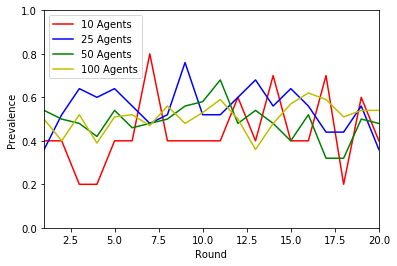

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

param_dict = {'size': 10,
              'prior': 0.5,
              'edge_prob': 0.1,
              'memory': 0,
              'rounds': 20}

sizes = [10, 25, 50, 100]
rounds = [i+1 for i in range(param_dict['rounds'])]
results10 = [0.0]*param_dict['rounds']
results25 = [0.0]*param_dict['rounds']
results50 = [0.0]*param_dict['rounds']
results100 = [0.0]*param_dict['rounds']


param_dict['size'] = 10
(agents_sdf, edges_sdf) = build_network(param_dict)
for i in range(param_dict['rounds']):
    agents_sdf = simulate_rounds_without_updating(agents_sdf, param_dict)
    prev = prevalence(agents_sdf)
    results10[i] = prev

del agents_sdf
del edges_sdf

param_dict['size'] = 25
(agents_sdf, edges_sdf) = build_network(param_dict)
for i in range(param_dict['rounds']):
    agents_sdf = simulate_rounds_without_updating(agents_sdf, param_dict)
    prev = prevalence(agents_sdf)
    results25[i] = prev

del agents_sdf
del edges_sdf

param_dict['size'] = 50
(agents_sdf, edges_sdf) = build_network(param_dict)
for i in range(param_dict['rounds']):
    agents_sdf = simulate_rounds_without_updating(agents_sdf, param_dict)
    prev = prevalence(agents_sdf)
    results50[i] = prev

del agents_sdf
del edges_sdf

param_dict['size'] = 100
(agents_sdf, edges_sdf) = build_network(param_dict)
for i in range(param_dict['rounds']):
    agents_sdf = simulate_rounds_without_updating(agents_sdf, param_dict)
    prev = prevalence(agents_sdf)
    results100[i] = prev
      
plt.plot(rounds, results10, 'r-', label='10 Agents') 
plt.plot(rounds, results25, 'b-', label='25 Agents') 
plt.plot(rounds, results50, 'g-', label='50 Agents') 
plt.plot(rounds, results100, 'y-', label='100 Agents') 
plt.axis([1,20,0,1])
plt.xlabel('Round')
plt.ylabel('Prevalence')
plt.legend()
plt.show()

As expected, we see that the variance in prevalence decreases with population size.

Sample network with 100 agents:

(100, 3)


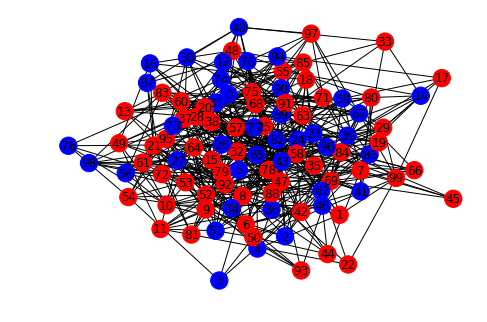

In [11]:
visualize_graph(edges_sdf, agents_sdf, param_dict)

## Prevalence with Prior Updating
In a network with 25 agents (10% connectivity), using an initial prior of 0.5 for every agent, we introduce updated priors into our model with zero memory. 

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

param_dict = {'size': 10,
              'prior': 0.5,
              'edge_prob': 0.1,
              'memory': 0,
              'rounds': 20}

rounds = [i+1 for i in range(param_dict['rounds'])]
results1 = [0.0]*param_dict['rounds']
results2 = [0.0]*param_dict['rounds']
results3 = [0.0]*param_dict['rounds']
results4 = [0.0]*param_dict['rounds']


(agents_sdf, edges_sdf) = build_network(param_dict)
edges_sdf = edges_sdf.persist(StorageLevel.MEMORY_AND_DISK).repartition(10, 'from_node').cache()
for i in range(param_dict['rounds']):
    agents_sdf = simulate_rounds_with_updating(agents_sdf, edges_sdf, param_dict)
    prev = prevalence(agents_sdf)
    results1[i] = prev

del agents_sdf
del edges_sdf

(agents_sdf, edges_sdf) = build_network(param_dict)
edges_sdf = edges_sdf_new.persist(StorageLevel.MEMORY_AND_DISK).repartition(10, 'node').cache()
for i in range(param_dict['rounds']):
    agents_sdf = simulate_rounds_with_updating(agents_sdf, edges_sdf, param_dict)
    prev = prevalence(agents_sdf)
    results2[i] = prev

del agents_sdf
del edges_sdf

(agents_sdf, edges_sdf) = build_network(param_dict)
edges_sdf = edges_sdf_new.persist(StorageLevel.MEMORY_AND_DISK).repartition(10, 'node').cache()
for i in range(param_dict['rounds']):
    agents_sdf = simulate_rounds_with_updating(agents_sdf, edges_sdf, param_dict)
    prev = prevalence(agents_sdf)
    results3[i] = prev

del agents_sdf
del edges_sdf

(agents_sdf, edges_sdf) = build_network(param_dict)
edges_sdf = edges_sdf_new.persist(StorageLevel.MEMORY_AND_DISK).repartition(10, 'node').cache()
for i in range(param_dict['rounds']):
    agents_sdf = simulate_rounds_with_updating(agents_sdf, edges_sdf, param_dict)
    prev = prevalence(agents_sdf)
    results4[i] = prev
      
plt.plot(rounds, results1, 'r-', label='1st Trial') 
plt.plot(rounds, results2, 'b-', label='2nd Trial') 
plt.plot(rounds, results3, 'g-', label='3rd Trial') 
plt.plot(rounds, results4, 'y-', label='4th Trial') 
plt.axis([1,20,0,1])
plt.xlabel('Round')
plt.ylabel('Prevalence')
plt.legend()
plt.show()

Py4JJavaError: An error occurred while calling o686.persist.
: java.lang.OutOfMemoryError: Java heap space
	at java.util.Arrays.copyOf(Arrays.java:3332)
	at java.lang.AbstractStringBuilder.ensureCapacityInternal(AbstractStringBuilder.java:124)
	at java.lang.AbstractStringBuilder.append(AbstractStringBuilder.java:448)
	at java.lang.StringBuilder.append(StringBuilder.java:136)
	at scala.collection.mutable.StringBuilder.append(StringBuilder.scala:210)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$generateTreeString$1.apply(TreeNode.scala:550)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$generateTreeString$1.apply(TreeNode.scala:549)
	at scala.collection.immutable.List.foreach(List.scala:381)
	at org.apache.spark.sql.catalyst.trees.TreeNode.generateTreeString(TreeNode.scala:549)
	at org.apache.spark.sql.catalyst.trees.TreeNode.generateTreeString(TreeNode.scala:568)
	at org.apache.spark.sql.execution.WholeStageCodegenExec.generateTreeString(WholeStageCodegenExec.scala:670)
	at org.apache.spark.sql.catalyst.trees.TreeNode.generateTreeString(TreeNode.scala:576)
	at org.apache.spark.sql.catalyst.trees.TreeNode.generateTreeString(TreeNode.scala:568)
	at org.apache.spark.sql.catalyst.trees.TreeNode.generateTreeString(TreeNode.scala:568)
	at org.apache.spark.sql.catalyst.trees.TreeNode.generateTreeString(TreeNode.scala:576)
	at org.apache.spark.sql.execution.WholeStageCodegenExec.generateTreeString(WholeStageCodegenExec.scala:670)
	at org.apache.spark.sql.catalyst.trees.TreeNode.generateTreeString(TreeNode.scala:576)
	at org.apache.spark.sql.execution.InputAdapter.generateTreeString(WholeStageCodegenExec.scala:396)
	at org.apache.spark.sql.catalyst.trees.TreeNode.generateTreeString(TreeNode.scala:576)
	at org.apache.spark.sql.execution.WholeStageCodegenExec.generateTreeString(WholeStageCodegenExec.scala:670)
	at org.apache.spark.sql.execution.InputAdapter.generateTreeString(WholeStageCodegenExec.scala:396)
	at org.apache.spark.sql.catalyst.trees.TreeNode.generateTreeString(TreeNode.scala:576)
	at org.apache.spark.sql.catalyst.trees.TreeNode.generateTreeString(TreeNode.scala:576)
	at org.apache.spark.sql.execution.WholeStageCodegenExec.generateTreeString(WholeStageCodegenExec.scala:670)
	at org.apache.spark.sql.catalyst.trees.TreeNode.generateTreeString(TreeNode.scala:576)
	at org.apache.spark.sql.execution.InputAdapter.generateTreeString(WholeStageCodegenExec.scala:396)
	at org.apache.spark.sql.catalyst.trees.TreeNode.generateTreeString(TreeNode.scala:576)
	at org.apache.spark.sql.execution.WholeStageCodegenExec.generateTreeString(WholeStageCodegenExec.scala:670)
	at org.apache.spark.sql.execution.InputAdapter.generateTreeString(WholeStageCodegenExec.scala:396)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$generateTreeString$3.apply(TreeNode.scala:574)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$generateTreeString$3.apply(TreeNode.scala:574)
	at scala.collection.immutable.List.foreach(List.scala:381)


## A Digression About Performance
The previous simulation tools were built with Apache Spark's dataframes and the SparkSQL library. These tools are well-designed for efficient parallel computation across many servers, but as I ran out of AWS credits, I am stuck running the simulations on my tired little 8GB MacBook. The overhead required by Spark's more intricate data model is heavy enough to become fairly slow when running moderate-sized jobs without multiple servers, resulting in "out of memory" errors when attempting the previous computation. It appears that we have fallen into the trap of premature optimization. As such, we implement the remaining simulation tasks with simple, lightweight Python data structures, taking care to ensure that our population sizes are small enough such that lack of parallelization is not a major issue.

Somehow, this actually worked and everything runs quite quickly.

## Doing Everything With Basic Python

In [114]:
import random
import copy

param_dict = {'size': 50,
              'prior': 0.5,
              'edge_prob': 0.1,
              'memory': 0,
              'rounds': 10}

def build_network2(params):
    edges = []
    for i in range(params['size']):
        for j in range(i+1, params['size']):
            x = random.random()
            if x < params['edge_prob']:
                edges.append([i,j])
                edges.append([j,i])
    
    network = {}
    agent = {'action': 0,
             'prior': params['prior'],
             'incoming': set(),
             'memory': params['memory']}
    for i in range(params['size']):
        network[i] = copy.deepcopy(agent)
    for e in edges:
        network[e[1]]['incoming'].add(e[0])
        
    return network
        
def simulate_all_actions2(network):
    for i in network:
        prob = random.random()
        if network[i]['prior'] > prob:
            network[i]['action'] = 1
        else:
            network[i]['action'] = 0
    
def update_all_priors2(network):
    for i in network:
        action_count = 0.0
        for j in network[i]['incoming']:
            action_count += network[j]['action']
        if len(network[i]['incoming']) > 0:
            network[i]['prior'] = (network[i]['prior']*network[i]['memory']) + (1 - network[i]['memory'])*(action_count / len(network[i]['incoming']))

def prevalence2(network):
    prev = 0.0
    for i in network:
        prev += network[i]['action']
    prev /= len(network)
    
    return prev

def simulate_rounds_with_updating2(network, params):
    for i in range(params['rounds']):
        simulate_all_actions2(network)
        update_all_priors2(network)

## Performance with Prior Updating, Take Two
In a network with 100 agents (10% connectivity), using an initial prior of 0.5 for every agent, we introduce updated priors into our model with zero memory. 

In [80]:
# Testing

params = {'size': 5,
          'prior': 0.5,
          'edge_prob': 1,
          'memory': 0,
          'rounds': 1}

network = build_network2(params)
simulate_all_actions2(network)
network

{0: {'action': 1, 'incoming': {1, 2, 3, 4}, 'memory': 0, 'prior': 0.5},
 1: {'action': 0, 'incoming': {0, 2, 3, 4}, 'memory': 0, 'prior': 0.5},
 2: {'action': 1, 'incoming': {0, 1, 3, 4}, 'memory': 0, 'prior': 0.5},
 3: {'action': 1, 'incoming': {0, 1, 2, 4}, 'memory': 0, 'prior': 0.5},
 4: {'action': 1, 'incoming': {0, 1, 2, 3}, 'memory': 0, 'prior': 0.5}}

## Visualizing Several Simulations
To demonstrate the types of patterns which occur as the simulations progress, we display the prevalence of the target behavior over time for 5 iterations of the simulation with our baseline parameters.

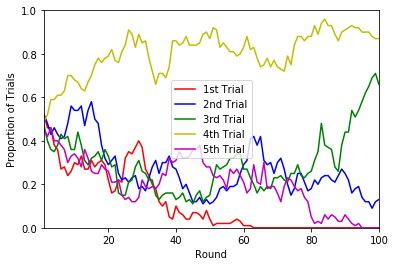

In [109]:
%matplotlib inline
import matplotlib.pyplot as plt

param_dict = {'size': 100,
              'prior': 0.5,
              'edge_prob': 0.1,
              'memory': 0.0,
              'rounds': 100}

rounds = [i+1 for i in range(param_dict['rounds'])]
results1 = [0.0]*param_dict['rounds']
results2 = [0.0]*param_dict['rounds']
results3 = [0.0]*param_dict['rounds']
results4 = [0.0]*param_dict['rounds']
results5 = [0.0]*param_dict['rounds']


network = build_network2(param_dict)
for i in range(param_dict['rounds']):
    simulate_rounds_with_updating2(network, params)
    prev = prevalence2(network)
    results1[i] = prev
    
network = build_network2(param_dict)
for i in range(param_dict['rounds']):
    simulate_rounds_with_updating2(network, params)
    prev = prevalence2(network)
    results2[i] = prev
    
network = build_network2(param_dict)
for i in range(param_dict['rounds']):
    simulate_rounds_with_updating2(network, params)
    prev = prevalence2(network)
    results3[i] = prev
    
network = build_network2(param_dict)
for i in range(param_dict['rounds']):
    simulate_rounds_with_updating2(network, params)
    prev = prevalence2(network)
    results4[i] = prev
    
network = build_network2(param_dict)
for i in range(param_dict['rounds']):
    simulate_rounds_with_updating2(network, params)
    prev = prevalence2(network)
    results5[i] = prev
      
plt.plot(rounds, results1, 'r-', label='1st Trial') 
plt.plot(rounds, results2, 'b-', label='2nd Trial') 
plt.plot(rounds, results3, 'g-', label='3rd Trial') 
plt.plot(rounds, results4, 'y-', label='4th Trial') 
plt.plot(rounds, results5, 'm-', label='5th Trial')
plt.axis([1,param_dict['rounds'],0,1])
plt.xlabel('Round')
plt.ylabel('Prevalence')
plt.legend()
plt.show()

## Visualizing Dispersion
To better understand the trends in behavioral dispersion which occur under different parameter settings, we conduct numerous simulations and display the proportion of trials for which the prevalence falls into each of 5 quintiles (with 0% and 100% excluded). We also display the proportion of trials where one of the behaviors reaches saturation.

In [116]:
%matplotlib inline
import matplotlib.pyplot as plt

def visualize_proportions(param_dict, title):
    rounds = [i+1 for i in range(param_dict['rounds'])]

    # (0,20)
    quint1 = [0.0]*param_dict['rounds']
    # [20,40)
    quint2 = [0.0]*param_dict['rounds'] 
    # [40,60)
    quint3 = [0.0]*param_dict['rounds']
    # [60,80)
    quint4 = [0.0]*param_dict['rounds']
    # [80,100)
    quint5 = [0.0]*param_dict['rounds']
    full = [0.0]*param_dict['rounds']
    empty = [0.0]*param_dict['rounds']

    #results = [[0.0]*param_dict['rounds']]*param_dict['trials']

    for i in range(param_dict['trials']):
        network = build_network2(param_dict)
        for j in range(param_dict['rounds']):
            simulate_rounds_with_updating2(network, params)
            prev = prevalence2(network)
            #results[i][j] = prev
            if prev == 0.0:
                empty[j] += 1
            elif prev < 0.2:
                quint1[j] += 1
            elif prev < 0.4:
                quint2[j] += 1
            elif prev < 0.6:
                quint3[j] += 1
            elif prev < 0.8:
                quint4[j] += 1
            elif prev < 1.0:
                quint5[j] += 1
            elif prev == 1.0:
                full[j] += 1

    for i in range(param_dict['rounds']):
        quint1[i] /= param_dict['trials']
        quint2[i] /= param_dict['trials']
        quint3[i] /= param_dict['trials']
        quint4[i] /= param_dict['trials']
        quint5[i] /= param_dict['trials']
        full[i] /= param_dict['trials']
        empty[i] /= param_dict['trials']


    plt.plot(rounds, quint1, 'r-', label='0-20% Prevalence') 
    plt.plot(rounds, quint2, 'm-', label='20-40% Prevalence') 
    plt.plot(rounds, quint3, 'b-', label='40-60% Prevalence') 
    plt.plot(rounds, quint4, 'c-', label='60-80% Prevalence') 
    plt.plot(rounds, quint5, 'y-', label='60-80% Prevalence')
    plt.plot(rounds, full, 'g-', label='100% Prevalence')
    plt.plot(rounds, empty, 'k-', label='0% Prevalence')
    plt.axis([1,param_dict['rounds'],0,1])
    plt.xlabel('Round')
    plt.ylabel('Proportion of Trials')
    plt.title(title)
    plt.legend()
    plt.show()

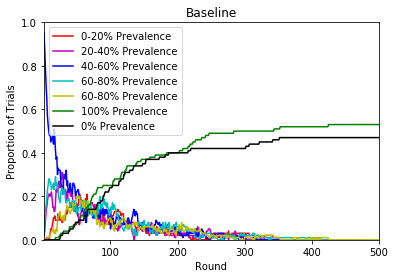

In [117]:
param_dict = {'size': 100,
              'prior': 0.5,
              'edge_prob': 0.1,
              'memory': 0.0,
              'rounds': 500,
              'trials': 100}

visualize_proportions(param_dict, 'Baseline')

## Adjusting Memory
The memory parameter controls the speed at which an agent learns from its neighbors. More concretely, memory controls the mixture between the old prior and the observed distribution when updating an agent's prior. If memory is zero, the prior will always be set to the observed distribution in the previous round. If memory is one, the prior will never update.

We maintain the baseline parameters for population (100), connectivity (10%), and starting prior (50%). We conduct 100 trials for 500 rounds each.

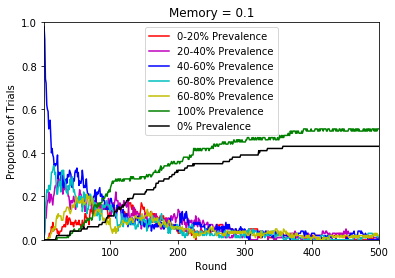

In [120]:
param_dict = {'size': 100,
              'prior': 0.5,
              'edge_prob': 0.1,
              'memory': 0.1,
              'rounds': 500,
              'trials': 100}

visualize_proportions(param_dict, 'Memory = 0.1')

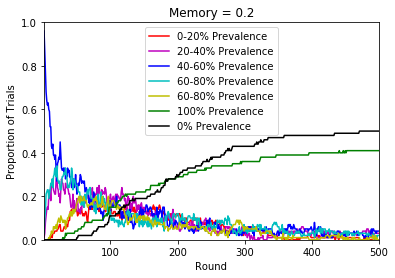

In [121]:
param_dict = {'size': 100,
              'prior': 0.5,
              'edge_prob': 0.1,
              'memory': 0.2,
              'rounds': 500,
              'trials': 100}

visualize_proportions(param_dict, 'Memory = 0.2')

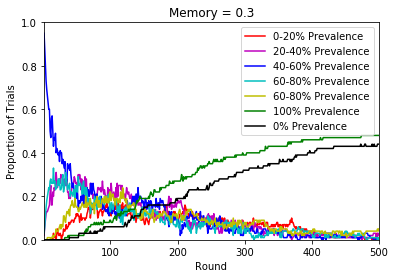

In [122]:
param_dict = {'size': 100,
              'prior': 0.5,
              'edge_prob': 0.1,
              'memory': 0.3,
              'rounds': 500,
              'trials': 100}

visualize_proportions(param_dict, 'Memory = 0.3')

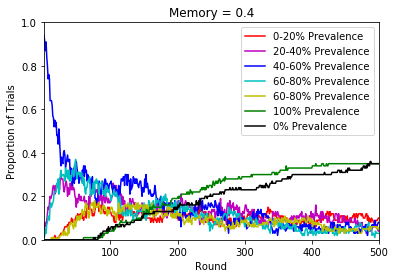

In [123]:
param_dict = {'size': 100,
              'prior': 0.5,
              'edge_prob': 0.1,
              'memory': 0.4,
              'rounds': 500,
              'trials': 100}

visualize_proportions(param_dict, 'Memory = 0.4')

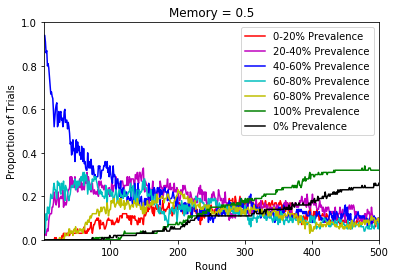

In [124]:
param_dict = {'size': 100,
              'prior': 0.5,
              'edge_prob': 0.1,
              'memory': 0.5,
              'rounds': 500,
              'trials': 100}

visualize_proportions(param_dict, 'Memory = 0.5')

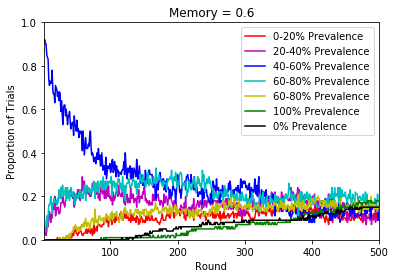

In [128]:
param_dict = {'size': 100,
              'prior': 0.5,
              'edge_prob': 0.1,
              'memory': 0.6,
              'rounds': 500,
              'trials': 100}

visualize_proportions(param_dict, 'Memory = 0.6')

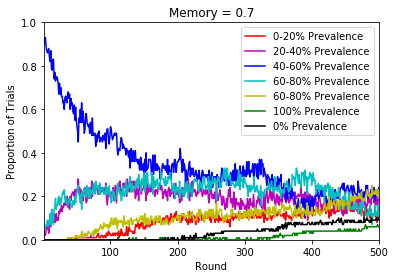

In [125]:
param_dict = {'size': 100,
              'prior': 0.5,
              'edge_prob': 0.1,
              'memory': 0.7,
              'rounds': 500,
              'trials': 100}

visualize_proportions(param_dict, 'Memory = 0.7')

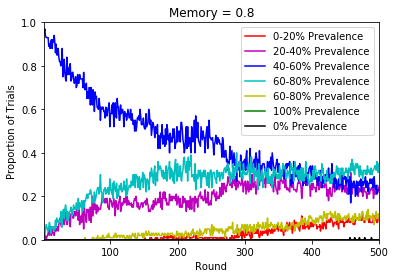

In [129]:
param_dict = {'size': 100,
              'prior': 0.5,
              'edge_prob': 0.1,
              'memory': 0.8,
              'rounds': 500,
              'trials': 100}

visualize_proportions(param_dict, 'Memory = 0.8')

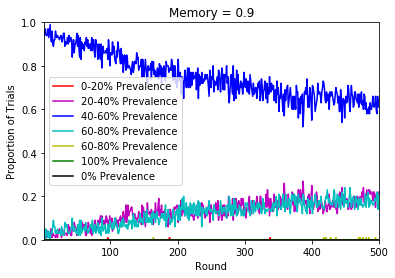

In [126]:
param_dict = {'size': 100,
              'prior': 0.5,
              'edge_prob': 0.1,
              'memory': 0.9,
              'rounds': 500,
              'trials': 100}

visualize_proportions(param_dict, 'Memory = 0.9')

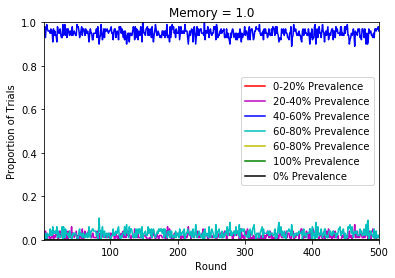

In [127]:
param_dict = {'size': 100,
              'prior': 0.5,
              'edge_prob': 0.1,
              'memory': 1.0,
              'rounds': 500,
              'trials': 100}

visualize_proportions(param_dict, 'Memory = 1.0')

As we can see from the visualizations above, increasing memory appears to decrease the speed at which behaviors disperse, resulting higher proportions of trials falling into the middle prevalence bands. For memory values above 0.7, the proportion of trials for which one of the behaviors reaches saturation in 500 rounds becomes quite small. As expected, when memory is set to 1, there is no change in behavior over time, with nearly every trial falling into the middle band. These results are not entirely surprising, but they allow us to represent an important behavioral phenomenon. When agents are less willing to adapt to new observations, favoring what they already know, . At a population level, this means. We will later see how this interacts with other behaviors.

## Changing Network Structures

In [ ]:
param_dict = {'size': 100,
              'prior': 0.5,
              'edge_prob': 0.1,
              'memory': 0.4,
              'rounds': 500,
              'trials': 100}

visualize_proportions(param_dict, 'Memory = 0.4')

## Trendsetters

## Changing Action Utilities